In [1]:
import os
import sys
import dill
import matplotlib.pyplot as plt
# Add the local src directory to the path
sys.path.append('./src/')

# Load the GBA_model class
from GBA_model import *
from GBA_trajectory import *

****TRAJECTORY WITHOUT NOISE****
- This function loads the model and condition via parameters.
- Use the "nameOfCSV" parameter to choose the filename for your CSV-File that captures values at max growthrate $ \mu $. (you dont need to set a name. It will autom. generate a fitting name)
- *Current Bug* : Protein (if not forced) reaches negative values for models C, D, EC12b at any condition. The function does not force positive Protein!!!!!

 current mu-Rate 0.7902048502452758
current gradient : [  0.          12.73431993   5.37311265   6.78012218 -12.09886039]
current protein [ 11.20707774  10.72797909   0.          57.60593358 234.95900959]
current Fluxvector  [171.14256647  97.52708262   0.         205.53228155 248.5194254 ]
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: True
 current mu-Rate 1.9131833334002817
current gradient : [ 0.          1.09456486 -0.65833258 -0.5792894   0.43946767]
current protein [ 21.70939265  35.08555473   3.5597163   61.20408063 151.80513035]
current Fluxvector  [331.52274493 318.95958842  34.95114853 541.722482   522.99520896]
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: True
    • Positive p: False
 current mu-Rate 0.7896492705156396
current gradient : [  0.          11.66259513   6.98252331   8.27764483 -12.89067713]
cur

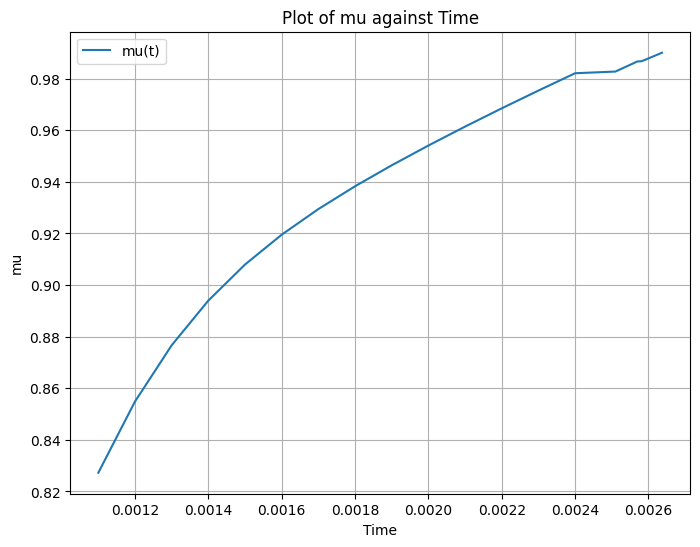

max μ rate :
0.9900861959937056


AssertionError: trajectory was stopped, because the model is consistent and the growthrate did not increase significantly for 5000 tries. 

In [2]:
#TRAJECTORY WITHOUT NOISE
trajectory(model_name = "D", condition = "2", max_time = 200, first_dt = 0.01, dt_changeRate = 0.1, nameOfCSV = None)

****TRAJECTORY WITH NOISE****
- Difference to "Without noise" : Draws a normaldistributed random number "epsilon" for ***next_f = np.add(next_f, (model.GCC_f[1:] + epsilon) * dt)***
- This function loads the model and condition via parameters.
- Use the "nameOfCSV" parameter to choose the filename for your CSV-File that captures values at max growthrate $ \mu $. (you dont need to set a name. It will autom. generate a fitting name + "noise")
- *Current Bugs* : Protein (if not forced) reaches negative values for models C, D, EC12b at any condition. The function does not force positive Protein!!!!!

In [ ]:
trajectoryWithNoise(model_name = "D", condition = "2", max_time = 200, first_dt = 0.01, dt_changeRate = 0.1, nameOfCSV = None)